### Indicate whether the similarity data, as reported in the data_influence data set, suggest that the identified influencers in fact influence the respective artists. Do the ‘influencers’ actually affect the music created by the followers? Are some music characteristics more ‘contagious’ than others, or do they all have similar roles in influencing a particular artist’s music?

In [2]:
import pandas as pd
import numpy as np
import networkx as nx
import ast
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

In [4]:
artists = pd.read_csv('data_by_artist.csv')
artists = artists.drop_duplicates(subset='artist_name', keep='last')
years = pd.read_csv('data_by_year.csv')
influence = pd.read_csv('influence_data.csv')

In [7]:
from tqdm import tqdm
#remove songs by artists that arent in the artists table
#duplicate songs w/ more than one artist
#takes my computer about a minute to run
#can ignore the warnings about setting a copy of a slice from a dataframe
full = pd.read_csv('full_music_data.csv')
allArtists = list(artists['artist_id'])
newdict = {}

full['artists_id'] = [int(x.split(',')[0][1:-1]) if len(x.split(',')) == 1 else [int(y) for y in x[1:-1].split(',')] for x in list(full['artists_id'])]
full['artist_names'] = [ast.literal_eval(x) if len(ast.literal_eval(x)) > 1 else ast.literal_eval(x)[0] for x in full['artist_names']]
floor = min(full['tempo'])
span = max(full['tempo']) - floor
full['tempo'] = [(x-floor)/span for x in full['tempo']]

last_id = 0
row = 0
for i in tqdm(range(len(full))): 
    thisRow = full.iloc[i,:]
    artIDs = thisRow['artists_id']
    artNames = thisRow['artist_names']
    
    if type(artIDs) == int:
        if artIDs == last_id: 
            thisRow['artists_id'] = artIDs
            thisRow['artist_names'] = artNames
            newdict[row] = thisRow.to_dict()
            row+=1
            last_id = artIDs
        else:
            if artIDs in allArtists:
                thisRow['artists_id'] = artIDs
                thisRow['artist_names'] = artNames
                newdict[row] = thisRow.to_dict()
                row+=1
                last_id = artIDs
                
    else:
        for j in range(len(artIDs)):
            artID = int(artIDs[j])
            artName = str(artNames[j])
            
            if artID in allArtists:
                thisRow['artists_id'] = artID
                thisRow['artist_names'] = artName
                newdict[row] = thisRow.to_dict()
                row+=1
    i+=1

full = pd.DataFrame.from_dict(newdict,'index')

artistGenres = {} #adds song genre to full
for i in tqdm(range(len(influence))):
    row = influence.iloc[i]
    influencer = row['influencer_id']
    follower = row['follower_id']
    infGenre = row['influencer_main_genre']
    folGenre = row['follower_main_genre']
    artistGenres[influencer] = infGenre
    artistGenres[follower] = folGenre

def getGenre(row):
    artist = row['artists_id']
    if type(artist) == list:
        print(row)
    try:
        genre = artistGenres[artist]
    except KeyError:
        genre = 'N/A'
    return genre

full['genre'] = full.apply(lambda row: getGenre(row), axis = 1)

full


  0%|          | 0/98340 [00:00<?, ?it/s]/Users/katherinefaiola/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/katherinefaiola/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/katherinefaiola/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-c

,artist_names,artists_id,danceability,energy,valence,tempo,loudness,mode,key,acousticness,instrumentalness,liveness,speechiness,explicit,duration_ms,popularity,year,release_date,song_title (censored),genre
0,Fat Freddy's Drop,178301,0.600,0.365,0.131,0.532777,-13.083,0,9,0.06720,0.585000,0.0921,0.0498,0,437200,54,2005,2005,Ernie,Electronic
1,Fat Freddy's Drop,178301,0.874,0.326,0.179,0.490063,-13.302,0,11,0.01360,0.148000,0.0993,0.1310,0,581008,53,2005,2005,Wandering Eye,Electronic
2,Fat Freddy's Drop,178301,0.670,0.531,0.336,0.571037,-8.267,0,9,0.01560,0.345000,0.3060,0.0377,0,431293,55,2009,8/7/2009,The Raft,Electronic
3,Alexander O'Neal,625201,0.761,0.702,0.850,0.429237,-8.523,1,7,0.10800,0.000031,0.0935,0.0389,0,304427,34,1991,1/1/1991,All True Man,R&B;
4,Alexander O'Neal,625201,0.661,0.828,0.902,0.471455,-12.673,0,11,0.27600,0.000001,0.2870,0.0390,0,264933,37,1987,7/29/1987,(What Can I Say) To Make You Love Me,R&B;
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102913,ZZ Top,690254,0.276,0.892,0.715,0.329693,-7.035,1,11,0.40900,0.000000,0.7140,0.0893,0,115973,33,1975,4/18/1975,Jailhouse Rock - **** Remaster,Pop/Rock
102914,ZZ Top,690254,0.700,0.592,0.906,0.450025,-10.434,1,11,0.10800,0.018400,0.1180,0.0681,0,263627,32,1976,11/29/1976,It's Only Love,Pop/Rock
102915,ZZ Top,690254,0.709,0.709,0.863,0.456977,-12.023,1,2,0.11800,0.000011,0.1250,0.0370,0,158400,31,1987,1987,Balinese,Pop/Rock
102916,ZZ Top,690254,0.552,0.651,0.533,0.661835,-10.624,0,4,0.00494,0.034900,0.1320,0.2290,0,232533,43,1992,4/13/1992,La Grange - **** Remaster,Pop/Rock


In [5]:
names = []
for i in artists['artist_name']:
    names.append(i)
influence = influence[influence['influencer_name'].isin(names)]
influence = influence[influence['follower_name'].isin(names)]
influence = influence.reset_index(drop=True)
influence.head()

,influencer_id,influencer_name,influencer_main_genre,influencer_active_start,follower_id,follower_name,follower_main_genre,follower_active_start
0,759491,The Exploited,Pop/Rock,1980,74,Special Duties,Pop/Rock,1980
1,25462,Tricky,Electronic,1990,335,PJ Harvey,Pop/Rock,1990
2,66915,Bob Dylan,Pop/Rock,1960,335,PJ Harvey,Pop/Rock,1990
3,71209,Leonard Cohen,Pop/Rock,1950,335,PJ Harvey,Pop/Rock,1990
4,91438,The Gun Club,Pop/Rock,1980,335,PJ Harvey,Pop/Rock,1990


In [8]:
artistStyle = full.groupby(['artist_names']).mean() #some values dont make sense to average but w/e

songStats = ['danceability', 'energy', 'valence', 'tempo', 'acousticness', 'instrumentalness', 'speechiness']

for edge in list(iGraph.edges())[:100]: #could combine this w/weighted influence scores to see how much they actually influence
    inf = edge[0] #the musical style of the people theys upposedly influence 
    fol = edge[1]
    infstats = artistStyle[artistStyle['artists_id'] == inf][songStats]
    folstats = artistStyle[artistStyle['artists_id'] == fol][songStats]
    a = cosine_similarity(infstats, folstats)

since60 = full[full['year'] >= 1960]
since60.groupby(['year','genre']).mean()

NameError: name 'iGraph' is not defined

In [10]:
# list of the 20 genres
genre = []
for i in influence['influencer_main_genre']:
    if i not in genre:
        genre.append(i)
for i in influence['follower_main_genre']:
    if i not in genre:
        genre.append(i)

In [12]:
# dictionary w key value pair of genre artists
artistByGenre = {}
for i in genre:
    artistByGenre[i] = []
i = 0
while i < len(influence):
    genreList = artistByGenre.get(influence['influencer_main_genre'][i])
    genreListF = artistByGenre.get(influence['follower_main_genre'][i])
    if influence['influencer_name'][i] not in genreList:
        genreList.append(influence['influencer_name'][i])
    if influence['follower_name'][i] not in genreListF:
        genreListF.append(influence['follower_name'][i])
    i += 1

In [179]:
# jazz song stats
jazzSongs = full[full['artist_names'].isin(artistByGenre.get('Jazz'))]
jazzSongs = jazzSongs.drop(['artist_names', 'artists_id', 'explicit', 'duration_ms', 'popularity', 'year', 'release_date', 'song_title (censored)'], axis=1)
jazzMeans = jazzSongs.mean(axis=0)
jazzMeans = jazzMeans.to_numpy()

In [155]:
# genre song stats
genreFeatures = []
for i in genre:
    songs = full[full['artist_names'].isin(artistByGenre.get(i))]
    songs = songs.drop(['artist_names', 'artists_id', 'explicit', 'duration_ms', 'popularity', 'year', 'release_date', 'song_title (censored)'], axis=1)
    means = songs.mean(axis=0)
    means = means.to_numpy()
    genreFeatures.append(means)

In [171]:
# jazz cosine similarity to other genres
i = 0
jazzsim = []
while i < len(genre):
    sim = cosine_similarity(jazzMeans.reshape(1, -1), genreFeatures[i].reshape(1, -1))
    jazzsim.append(sim[0][0])
    i += 1

In [173]:
# jazz cosine similarity df
d = {'Genre' : genre, 'Cosine Similarity' : jazzsim}
jazzSimilarity = pd.DataFrame(data=d)
jazzSimilarity = jazzSimilarity.sort_values(by=['Cosine Similarity'], ascending = False)
jazzSimilarity = jazzSimilarity.reset_index(drop=True)
jazzSimilarity

,Genre,Cosine Similarity
0,Jazz,1.000000
1,Avant-Garde,0.999892
2,Easy Listening,0.999821
3,Folk,0.999606
4,Stage & Screen,0.998424
5,Vocal,0.998347
6,Comedy/Spoken,0.997561
7,Classical,0.996964
8,New Age,0.996319
9,International,0.995279


In [202]:
# songs stats by genre
for i in genre:
    songs = full[full['artist_names'].isin(artistByGenre.get(i))]
    songs = songs.drop(['artist_names', 'artists_id', 'explicit', 'duration_ms', 'popularity', 'year', 'release_date', 'song_title (censored)'], axis=1)
    means = songs.mean(axis=0)
    print(i)
    print(means['tempo'])

Pop/Rock
0.5041980713608971
Electronic
0.49042630707112583
Reggae
0.4774755289800211
Jazz
0.462278082020503
Country
0.4900360207138811
Comedy/Spoken
0.43481045095581794
R&B;
0.47720687330073297
Classical
0.4364707118746228
Latin
0.4904744919256894
Vocal
0.4515249429416114
Folk
0.4755359158889776
Easy Listening
0.4548916454260138
International
0.4750882932243574
Avant-Garde
0.45780935105224024
Blues
0.4824690364704632
Stage & Screen
0.4256400818155745
New Age
0.4554467713904153
Religious
0.4926720395705324
Children's
0.4874728923340553
Unknown
0.49486651100803203


In [13]:
# R&B df, sort by year, reset index
RBSongs = full[full['artist_names'].isin(artistByGenre.get('R&B;'))]
RBSongs = RBSongs.sort_values(by='year')
RBSongs = RBSongs.reset_index(drop=True)
RBSongs.head()

,artist_names,artists_id,danceability,energy,valence,tempo,loudness,mode,key,acousticness,instrumentalness,liveness,speechiness,explicit,duration_ms,popularity,year,release_date,song_title (censored),genre
0,Screamin' Jay Hawkins,309458,0.845,0.455,0.896,0.356433,-13.668,0,5,0.710,0.420000,0.055,0.0488,0,145933,2,1927,1927,I Put A Spell On You - Live,R&B;
1,Aretha Franklin,927555,0.496,0.829,0.733,0.487597,-8.876,0,5,0.629,0.076800,0.162,0.0519,0,161893,0,1927,1927,Evil **** ***** - Live,R&B;
2,Chuck Willis,126144,0.556,0.476,0.730,0.700698,-6.766,1,10,0.959,0.002400,0.242,0.0778,0,132733,0,1932,1932,Take It Like A Man (with The Royals),R&B;
3,Aretha Franklin,927555,0.648,0.356,0.529,0.355339,-13.917,0,7,0.896,0.000036,0.110,0.0837,0,186160,3,1936,1936,It Ain't Necessarily So - from ***** and Bess,R&B;
4,Deborah Cox,234647,0.609,0.447,0.411,0.335793,-6.697,1,10,0.653,0.000000,0.115,0.0352,0,193147,4,1941,1941,Fine and Mellow,R&B;


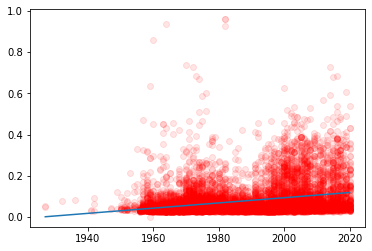

In [14]:
# visual of the progression of loudness feature in songs
year = RBSongs['year']
loudness = RBSongs['speechiness']
plt.plot(year, loudness, 'ro', alpha=0.1)
plt.plot(np.unique(year), np.poly1d(np.polyfit(year, loudness, 1))(np.unique(year)))

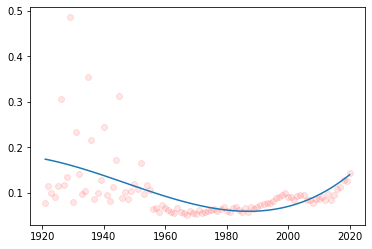

In [433]:
# visual of the progression of speachiness feature in songs
year = years['year']
attribute = years['speechiness']
plt.plot(year, attribute, 'ro', alpha=0.1)
plt.plot(np.unique(year), np.poly1d(np.polyfit(year, attribute, 3))(np.unique(year)))

In [403]:
# maybe dbl check the specs for accuracy
def diffGen(name):
    """calculates the difference in percentage of mean stat btwn genres"""
    df = artists[artists['artist_name'] == name]
    df = df.drop(['artist_name', 'artist_id', 'duration_ms', 'popularity', 'count', 'mode', 'key', 'liveness'], axis=1)
    df = pd.DataFrame(df.mean(axis=0))
    df = df.reset_index()
    df = df.rename(columns={'index': 'Characteristic', 0: 'Mean'})
    ID = artists.loc[artists['artist_name'] == name, 'artist_id']
    ID = list(ID)
    i = 0
    length = 0
    while length < 1:
        length = len(list(iGraph.successors(int(ID[i]))))
        if length > 0:
            break
        i += 1
    f = artists[artists['artist_id'].isin(list(iGraph.successors(int(ID[i]))))]
    f = f.drop(['artist_name', 'artist_id', 'duration_ms', 'popularity', 'count', 'mode', 'key', 'liveness'], axis=1)
    f = pd.DataFrame(f.mean(axis=0))
    f = f.reset_index()
    f = f.rename(columns={'index': 'Characteristic', 0: 'Mean'})
    df['Difference in %'] = abs((df['Mean'] - f['Mean'])/df['Mean']) * 100
    j = 0
    while i < len(df):
        if df['Difference in %'][i] == float('inf'):
            df.at[i, 'Difference in %'] = 100
        i += 1
    return df

In [404]:
# diff in % for jazz w/ miles davis 
average = diffGen('Miles Davis')
average['All Jazz'] = average['Difference in %']
for i in jazzRoots['Influencer']:
    df = diffGen(i)
    average['All Jazz'] = average['All Jazz'] + df['Difference in %']
average['All Jazz'] = average['All Jazz']/len(jazzRoots)
average

,Characteristic,Mean,Difference in %,All Jazz
0,danceability,0.460221,10.526189,17.572490
1,energy,0.308229,53.177014,62.175926
2,valence,0.417860,20.194747,34.530507
3,tempo,113.550382,0.528045,10.050108
4,loudness,-14.526619,9.457358,21.005121
5,acousticness,0.655711,25.706516,298.464444
6,instrumentalness,0.205073,59.418083,207186.178870
7,speechiness,0.054571,15.638073,36.265284
